# << Cats vs Dogs >>

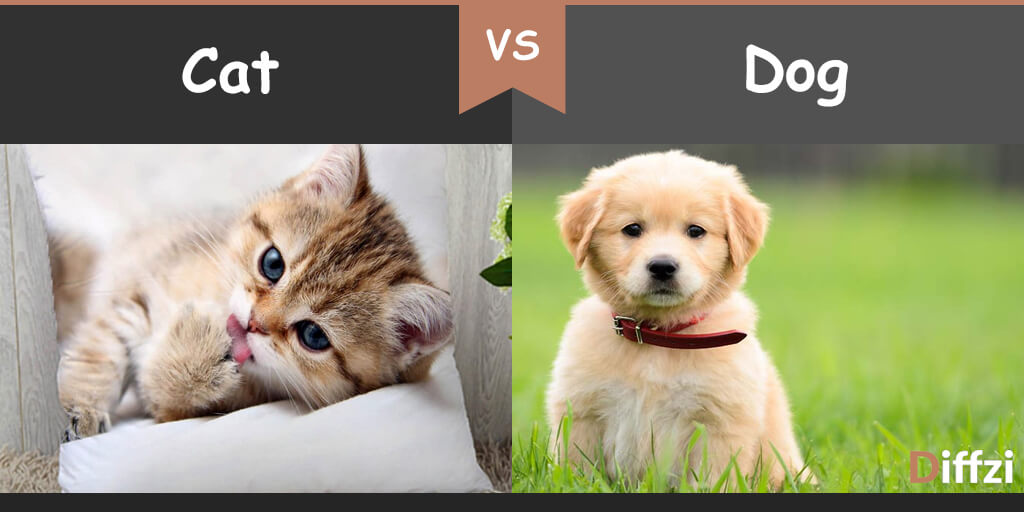

# [목차]
## 1. Setting Dataset
## 2. Data Pre-Processing
## 3. Prepare Model
##    - Callback
##    - Prepare Data
##    - Generator
## 4. Processing Model
## 5. Final Model
##    - Fit Model
## 6. Predict

# 1. Setting Dataset

## Import Library

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import zipfile
import os
print(os.listdir("../input/dogs-vs-cats"))

## Dataset 가져오기

In [ ]:
# zip파일 압축해제하기
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")

In [ ]:
# Dataset count
print(len(os.listdir('/kaggle/working/train')), 'training data')
print(len(os.listdir('/kaggle/working/test1')), 'test data')

# 2. Data Pre-Processing

## Prepare Training Data

In [ ]:
os.listdir("/kaggle/working/train")[:5]

> #### Training data에 대해 dogs->1, cats->0 에 대한 각 레이블 생성한다.

In [ ]:
filenames = os.listdir("/kaggle/working/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':       # dog면 1
        categories.append(1)
    else:                       # cat이면 0
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

## See Total In Conut

In [ ]:
# category에 분류된 dog, cat의 수 보기
df['category'].replace({0: 'cat', 1:'dog'}).value_counts()

In [ ]:
# 시각화해보기
df['category'].value_counts().plot.bar()

## See Sample Image

In [ ]:
sample = random.choice(filenames) # filenames로 되어있는 경로의 파일 중 램덤으로 1개 선택
image = load_img("/kaggle/working/train/" +sample) # 랜덤으로 선택된 파일의 이름 가져오기
plt.imshow(image) # 가져온 파일 이미지화

# 3. Prepare Model
> ### Callback, Prepare Data, Generator

## 1) Callback
> #### Callback(EarlyStopping, ReduceLROnPlateau)

> #### EarlyStopping - Early Stop
> - 과적합을 방지하기 위해 val_loss 값을 감소시키지 않은 상태로 n epoch 후에 학습을 정지시킨다.
>
> #### ReduceLRonPlateau - Learning Rate Reduction
> - n epoch 동안 val_acc가 증가하지 않으면 학습률을 감소시킨다.

In [ ]:
# 학습 조기종료를 사용하기 위해 import 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=15) # 학습 조기종료
# ㄴ overfitting을 막기 위해 15epoch 만큼 올라가 볼 때 val_loss 값이 감소하지 않으면 학습을 중단 

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_acc', # ReduceLROnPlateau의 기준이 되는 값 : val_acc 
    patience = 2,        # 학습률이 감소한 후 개선되지 않은 epoch 수,
                         # Training이 진행됨에도 더이상 monitor되는 값의 개선이 없을 경우 몇 번의 epoch을 진행하고 learning rate를 조정할지 정한다.
    verbose = 1,         # 얼마나 자세하게 정보를 표시할 것인가를 지정(0, 1, 2)
                         # 0 : 화면에 나타냄 없이 종료 
                         # 1 : EarlyStopping이 적용될 때 화면에 적용되었다고 나타남 
    factor = 0.5,        # Learning rate를 얼마나 감소시킬 지 정하는 인자 값  
                         # - ( 새로운 learning rate = 기존 learning rate * factor )
    min_lr = 0.00001     # 학습률의 하한선
)

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

## 2) Prepare Data

In [ ]:
# 현재 category의 형태 : 정수형
df.head()

> #### 아래에 나오는 Generator 에서 class_mode = 'categorical' 를 사용할 예정이므로 문자열로 바꿔줘야 한다. ( 1 -> dog, 0 -> cat )

In [ ]:
# 현재 0과 1로 표기 -> cat과 dog로 변경
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

df.head() # 변경됐는지 확인

In [ ]:
# train과 vaild, temp_test 분류
train_valid_df, temp_test_df = train_test_split(df, test_size=0.02, random_state=42) # test_size = 0.02 : 전체 데이터의 2%를 검증용 데이터로 만든다.
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2, random_state=42) # test_size = 0.2 : 위의 2%를 빼고 나머지 98% 데이터에서 20%는 valid, 80%는 train data로 생성 

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
temp_test_df = temp_test_df.reset_index(drop=True)

train_df.shape, valid_df.shape, temp_test_df.shape

In [ ]:
train_df

In [ ]:
train_df['category'].value_counts()

In [ ]:
valid_df

In [ ]:
valid_df['category'].value_counts()

In [ ]:
total_train = train_df.shape[0]
total_validate = valid_df.shape[0]
total_temp_test = temp_test_df.shape[0]

In [ ]:
print(total_train, ',', total_validate, ',', total_temp_test)

## 3) Generator (Data Augmentation)

In [ ]:
IMAGE_WIDTH = 128                        # 이미지 너비(행)
IMAGE_HEIGHT = 128                       # 이미지 높이 (열)
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT) # 이미지 크기
IMAGE_CHANNELS = 3                       # 이미지 channel(깊이)
batch_size = 32

In [ ]:
# 신경망 모델의 성능을 높이기 위한 데이터 부풀리기(Data augmentation) - Overfitting 방지 방법
train_datagen = ImageDataGenerator( # ImageDataGenerator : 학습 도중에 이미지에 임의 변형 및 정규화
    rotation_range = 15,            # 지정된 각도(0 ~ 15) 범위내에서 임의로 원본이미지를 회전시킨다.
    rescale = 1./255,               # 1/255로 스케일링하여 0-1 범위로 변환시켜줌
    # ㄴ 원본 영상 0-255의 RGB 계수로 구성되는 입력값은 모델을 효과적으로 학습시키기에 너무 높다.
    shear_range = 0.1,              # 층밀리기 강도 (범위 내에서 층을 반시계방향으로 민다.)
    zoom_range = 0.2,               # 임의로 원본이미지를 확대/축소
    horizontal_flip = True,         # 좌우 반전 : 50% 확률로 이미지를 수평으로 뒤집는다.
    width_shift_range = 0.1,        # 수평방향 이동 범위내에서 임의로 원본이미지를 이동시킴 - 전체 너비의 비율을 나타냄
    height_shift_range = 0.1        # 수직방향 이동 범위내에서 임의로 원본이미지를 이동시킴 - 전체 높이의 비율을 나타냄
)

## See how our generator work

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True) # train set인 train_df에서 n=1개를 sample 함
example_generator = train_datagen.flow_from_dataframe(
    example_df, # dataframe
    "./train/", # 디렉토리 위치
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

> #### 카테고리 별로 분류하기 위해 class_mode를 categorical로 사용
> * #### 0 -> cat, 1 -> dog

<br>

> #### class_mode ( default : categorical )
> * #### binary : 1D numpy array of binary labels (binary 레이블의 1D numpy 배열 )
> * #### categorical : 2D numpy array of one-hot-encoding labels. ( One-Hot-Encoding 된 레이블의 2D numpy 배열 ) -> 자동으로 원-핫-인코딩 수행
> * #### sparse : 1D numpy array of integer labels ( 정수 레이블의 1D numpy 배열 )
> * #### input : images identical to input images ( 입력 이미지와 동일한 이미지 )


In [ ]:
# sample 된 데이터 확인
example_df

In [ ]:
image = load_img("./train/" +example_df['filename'][0]) # example_df의 원본 이미지 보기
plt.imshow(image) # 가져온 파일 이미지화

In [ ]:
plt.figure(figsize=(12, 12)) # plot 출력 크기 설정
for i in range(0, 15):       # 총 15개의 이미지를 출력
    plt.subplot(5, 3, i+1)   # 이미지 출력 위치 설정
    for x_batch, y_batch in example_generator: # exaple_generator를 통해 원본 이미지 변형
        image = x_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [ ]:
# dataframe 과 디렉토리의 위치를 전달받아 증강/정규화된 데이터의 배치를 생성
train_generator = train_datagen.flow_from_dataframe( # 데이터프레임을 불러오는 함수
    train_df,                                        # 아까 split한 train dataframe
    "./train/",                                      # 전체 data가 있는 디렉토리 경로
    x_col = 'filename',                              # train_df DataFrame에 filename col의 값들을 가져옴
    y_col = 'category',                              # train_df DataFrame에 category col의 값들을 가져옴
    target_size = IMAGE_SIZE,                        # 모든 이미지의 크기를 재조정할 치수 - 디폴트 값(256, 256)
    class_mode = 'categorical', 
    batch_size = batch_size
)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    valid_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# 4. Processing Model
## PPT 참고

# 5. Final Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Activation, BatchNormalization


model = Sequential()

# block 1 ( VGGNet 구현 3*3 레이어 추가 )
model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)))  # (126, 126, 32)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3, 3), strides=2))  # (62, 62, 64)
model.add(BatchNormalization())
model.add(Activation('relu'))


# block 2
model.add(Conv2D(64, (3, 3)))  # (60, 60, 64)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(128, (3, 3), strides=2))  # (29, 29, 128)
model.add(BatchNormalization())
model.add(Activation('relu'))


# block 3
model.add(Conv2D(128, (3, 3)))  # (27, 27, 128)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(256, (3, 3), strides=2))  # (13, 13, 256)
model.add(BatchNormalization())
model.add(Activation('relu')) 


# block 4
model.add(Conv2D(256, (3, 3)))  # (11, 11, 256)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(512, (3, 3), strides=2))  # (5, 5, 512)
model.add(BatchNormalization())
model.add(Activation('relu')) 


# block 5
model.add(Conv2D(512, (3, 3)))  # (3, 3, 512)
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(1024, (3, 3), strides=2))  # (1, 1, 1024)
model.add(BatchNormalization())
model.add(Activation('relu')) 

# Output
model.add(GlobalAveragePooling2D()) # Flatten 대신 GAP 사용 (GoogleNet 논문 적용, 과적합 방지 효과)

model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))  # cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.summary()

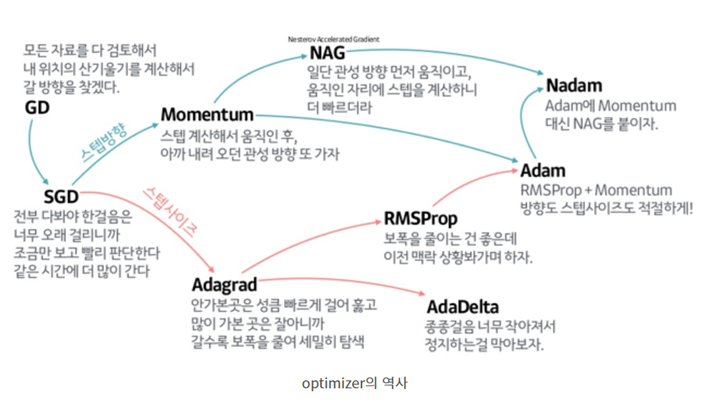

> ### Optimizer : 학습 속도를 빠르고 안정적이게 하는 방법
> - 방향성 고려
>   - Momentum
>   - NAG
> - 스텝 사이즈 고려
>   - Adagrad
>   - RMSProp
>   - AdaDelta
> - 방향성 + 스텝사이즈
>   - Adam ( Momentum + RMSProp )
>   - Nadam ( NAG + Adam )
>     - 스텝 방향 : 최대한 일직선 (휘지 않도록)
>     - 스텝 속도 : 최대한 빠르게

## Fit Model

In [ ]:
epochs = 30
history = model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

## Virtualize Training

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label='Training loss')
ax1.plot(history.history['val_loss'], color='r', label='Validation loss')
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Save Model

In [ ]:
model.save_weights('model.h5')

# 6. Predict

## Predict Target Data

In [ ]:
# test data
temp_test_datagen = ImageDataGenerator(rescale=1./255)
temp_test_generator = temp_test_datagen.flow_from_dataframe(
    temp_test_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict(
    temp_test_generator, # temp_test_generator : 입력 샘플의 batch를 생성하는 생성기
    steps = np.ceil(total_temp_test/batch_size) # np.ceil : 올림, 중지되기 전까지 generator로 부터 얻는 단계의 총 갯수
)

In [ ]:
temp_test_df['predict'] = np.argmax(predict, axis=-1)

In [ ]:
temp_test_df

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())  # {0: 'cat', 1: 'dog'}


temp_test_df['category'] = temp_test_df['category'].replace(label_map)
temp_test_df['category'] = temp_test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
temp_test_df[0:100]

In [ ]:
accuracy_count = 0  # 정답 맞춘 개수

for i in range(total_temp_test):
    
    accuracy_count += ( temp_test_df['category'][i] == temp_test_df['predict'][i] )

print('정답일 확률 : {:.3f}'. format(float(accuracy_count/total_temp_test)))
print('정답 맞춘 개수 : 500개 중 {}개'.format(accuracy_count))

In [ ]:
check = temp_test_df.head(12)
check.head()
plt.figure(figsize=(12, 24))
for index, row in check.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Predict Test Data

In [ ]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame(
    {'filename': test_filenames}
)
test = test_df.shape[0]

In [ ]:
test

In [ ]:
test_df

In [ ]:
# test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict2 = model.predict(
    test_generator, # test_generator : 입력 샘플의 batch를 생성하는 생성기
    steps = np.ceil(test/batch_size) # np.ceil : 올림, 중지되기 전까지 generator로 부터 얻는 단계의 총 갯수
)

In [ ]:
test_df['predict'] = np.argmax(predict2, axis=-1)

In [ ]:
test_df

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())  # {0: 'cat', 1: 'dog'}


test_df['predict'] = test_df['predict'].replace(label_map)
test_df['predict'] = test_df['predict'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df[0:100]

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['predict']
submission_df.drop(['filename', 'predict'], axis=1, inplace=True)
submission_df.to_csv('submission_final.csv', index=False)

In [ ]:
submission_df.head(10)

In [ ]:
check = test_df.head(12)
check.head()
plt.figure(figsize=(12, 24))
for index, row in check.iterrows():
    filename = row['filename']
    category = row['predict']
    img = load_img("/kaggle/working/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()